In [10]:
training_data_directory = 'soil_train'
test_data_directory = 'soil_valid'

In [11]:
import os
import re
import cv2
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [12]:
#data processing tools
training_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)

test_data_processor = ImageDataGenerator(rescale = 1./255)

training_data = training_data_processor.flow_from_directory(
    training_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
)

validation_generator = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256 ,256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)
img,labels= next(training_data)
print(img.shape)

Found 492 images belonging to 4 classes.
Found 136 images belonging to 4 classes.
(32, 256, 256, 3)


In [13]:
#model parameters
num_conv_layers = 2
num_dense_layers = 1
layer_size = 32
num_training_epochs =10
MODEL_NAME = 'soil'

In [14]:
import time
from keras.models import Sequential
import multiprocessing as mp

#number of threads
num_threads = 4

# Set OpenMP environment variables
os.environ["OMP_NUM_THREADS"] = str(num_threads)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"

model = Sequential()

model.add(Conv2D(layer_size, (3, 3), input_shape=(256,256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# reduce dimensionality
model.add(Flatten())

#parallelize the dense layers using OpenMP
dense_layers = [(layer_size,) for _ in range(num_dense_layers)]
activations = [("relu",) for _ in range(num_dense_layers)]
with mp.Pool(num_threads) as p:
    p.starmap(model.add, [(Dense(*args),) for args in dense_layers])
    p.starmap(model.add, [(Activation(*args),) for args in activations])

#output layer
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'],
                )

start = time.time()

model.fit(training_data,
            epochs=num_training_epochs,
            validation_data = validation_generator)
end = time.time()
print("Parallel time:", end-start)
# save the trained model
model.save('models/parallel_model.h5')

Epoch 1/10
16/16 [==============================] - 32s 2s/step - loss: 2.2800 - accuracy: 0.3211 - val_loss: 2.1847 - val_accuracy: 0.1544
Epoch 2/10
16/16 [==============================] - 25s 2s/step - loss: 1.0794 - accuracy: 0.4593 - val_loss: 1.0759 - val_accuracy: 0.4926
Epoch 3/10
16/16 [==============================] - 25s 2s/step - loss: 0.8962 - accuracy: 0.5528 - val_loss: 2.0760 - val_accuracy: 0.3676
Epoch 4/10
16/16 [==============================] - 26s 2s/step - loss: 0.8272 - accuracy: 0.6443 - val_loss: 1.2703 - val_accuracy: 0.5074
Epoch 5/10
16/16 [==============================] - 25s 2s/step - loss: 0.8315 - accuracy: 0.6606 - val_loss: 1.0299 - val_accuracy: 0.6250
Epoch 6/10
16/16 [==============================] - 26s 2s/step - loss: 0.8317 - accuracy: 0.6484 - val_loss: 1.6047 - val_accuracy: 0.4485
Epoch 7/10
16/16 [==============================] - 26s 2s/step - loss: 0.8057 - accuracy: 0.6585 - val_loss: 1.2612 - val_accuracy: 0.5588
Epoch 8/10
16/16 [==

1/1 [==============================] - 0s 81ms/step
Predicted Soil Type: Clayey Soil
 Soil Type: Fertile Soil 
 Suitable Crops: paddy
Predicted Soil Type: clayeysoil
Time taken for prediction: 0.0030019283294677734 seconds


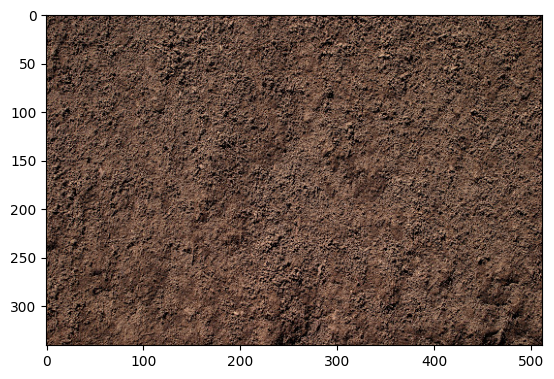

In [20]:
import time
from tensorflow.keras.preprocessing import image
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
from tensorflow.keras.models import load_model
from concurrent.futures import ThreadPoolExecutor

def select_image():
    root = tk.Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(initialdir = test_data_directory, title = 'Select Image File', filetypes = (('JPEG Files', '*.jpg'), ('PNG Files', '*.png'), ('All Files', '*.*')))
    return file_path

def print_soil_info(predicted_value, soil_type, info):
    if predicted_value == soil_type:
        print(info)
        return True
    return False

def make_prediction(model):
    image_fp = select_image()
    im = cv2.imread(image_fp)  # load image
    plt.imshow(im[:, :, [2, 1, 0]])
    img = image.load_img(image_fp, target_size=(256, 256))
    img = image.img_to_array(img)

    image_array = img / 255.0  # scaling the image
    img_batch = np.expand_dims(image_array, axis=0)


    class_ = ["sandysoil", "clayeysoil", "loamsoil", "redsoil"]  # possible output values
    predicted_value = class_[np.argmax(model.predict(img_batch))]
    true_value = re.search(r'(sandysoil)|(clayeysoil)|(loamsoil)|(redsoil)', image_fp)[0]

    soil_info = {
        "clayeysoil": "Predicted Soil Type: Clayey Soil\n Soil Type: Fertile Soil \n Suitable Crops: paddy",
        "loamsoil": "Predicted Soil Type: Loam soil\n Soil Type: Fertile Soil \n Suitable Crops: cotton,jute and sugarcane",
        "redsoil": "Predicted Soil Type: red Soil\n Soil Type: Fertile Soil \n Suitable Crops: cotton, wheat, rice, pulses, millets, tobacco, oilseeds, potatoes, and fruits",
        "blacksoil": "Predicted Soil Type: Sandy Soil\n Soil Type: Unfertile Soil",
    }
    start_time = time.time()  # Start time

    with ThreadPoolExecutor(max_workers=4) as executor:
        for soil_type, info in soil_info.items():
            if executor.submit(print_soil_info, predicted_value, soil_type, info).result():
                break

    end_time = time.time()  # End time

    time_taken = end_time - start_time  # Time taken for prediction

    out = f"""Predicted Soil Type: {predicted_value}"""

    return out, time_taken

# load the model
model_path ='models/parallel_model.h5'
model = load_model(model_path)

# make prediction
prediction, time_taken = make_prediction(model)
print(prediction)
print("Time taken for prediction:", time_taken, "seconds")
